<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentação de Clientes

## 1) Introdução

Neste trabalho iremos analisar a base de dados disponibilizada online pela Olist.

Esta base refere-se ao desenvolvimento do comércio eletrônico no Brasil nos últimos anos, apresentando informações tanto das compras realizadas, quanto dos clientes que as fizeram, dos vendedores envolvidos e dos produtos comercializado neste tempo.

Nosso objetivo é explorar esta base de dados para tirar informações relevantes para serem utilizadas nos negócios, culminando com uma segmentação dos clientes, onde estes possam ser classificados de acordo com sua assiduidade às compras online.

## 2) Preparação dos dados

In [1]:
! pip install squarify
! pip install pyod

In [2]:
# Importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pyod.models.knn import KNN
import squarify
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
! git clone https://github.com/Mario-RJunior/olist-e-commerce

fatal: destination path 'olist-e-commerce' already exists and is not an empty directory.


### 2.1) Gerando o dataframe

Para gerar um dataframe, iremos carregar os arquivos ***.csv*** de forma independente e depois iremos juntá-los uns aos outros através das chaves correspondentes.

In [4]:
# Carregando os datasets
customer = pd.read_csv('olist-e-commerce/datasets/olist_customers_dataset.csv')
orders = pd.read_csv('olist-e-commerce/datasets/olist_orders_dataset.csv')
orders_items = pd.read_csv('olist-e-commerce/datasets/olist_order_items_dataset.csv')

In [5]:
# Junção dos dataframes
df = pd.merge(right=orders,
             left=customer,
             on='customer_id')

df = pd.merge(right=orders_items,
             left=df,
             on='order_id')

In [6]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [7]:
print(f'Número de linhas: {df.shape[0]} \nNúmero de colunas: {df.shape[1]}')

Número de linhas: 112650 
Número de colunas: 18


### 2.2) Verificando a consistência dos dados

Para utilizar nosso dataframe da forma ideal, precisamos inicialmente ter certeza que os dados estão consistentes, ou seja, no formato ideal, que não há valores faltantes na tabela, etc. Checaremos essas condições a seguir.

In [8]:
# Convertendo a coluna "order_purchase_timestamp" para o formato datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [9]:
# Confirmando os tipos dos dados de cada coluna
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
dtype: object

In [10]:
# Verificando os valores nulos
df.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

## 3) Modelo RFM

O modelo RFM é largamente utilizado para segmentação de clientes, levando em consideração as respectivas características:

- ***Recência (Recency)***: total de dias em que o cliente não realiza uma compra.
- ***Frequência (Frequency)***: número total de compras que o cliente já realizou.
- ***Monetaridade (Monetary)***: gasto total do cliente.

Iremos então descobrir cada uma dessas variáveis a partir do dataframe obtido acima.

### 3.1) Selecionando as colunas

Aqui criaremos um dataframe levando em consideração algumas colunas específicas para utlizar o modelo RFM. Para isso, excluiremos algumas colunas do dataframe original, deixando apenas as features que são mais relevantes para cada caso. Chamaremos este dataframe de ***df_temp*** para indicar que este é um dataframe temporário e será alterado posteriormente.

In [11]:
df_temp = df.drop(columns=['customer_id', 'product_id',
                        'customer_zip_code_prefix', 'customer_city', 
                        'customer_state', 'order_status', 'order_approved_at', 
                        'order_delivered_carrier_date', 
                        'order_delivered_customer_date',
                        'order_estimated_delivery_date', 'order_item_id', 
                        'seller_id', 'shipping_limit_date',
                        'freight_value'])
df_temp.head()

,customer_unique_id,order_id,order_purchase_timestamp,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,230.00


- Data de Referência

Para calcularmos a recência, precisamos ter uma data de referência para podermos saber exatamente quantos dias cada cliente não realiza uma compra. Esta data será equivalente a um dia após a data da última compra registrada na base de dados e é calculada a seguir.

In [12]:
# Criando uma data de referência
data_referencia = df_temp['order_purchase_timestamp'].max() + timedelta(days=1)
print(f'Data de referência: {data_referencia}')

Data de referência: 2018-09-04 09:06:57


Agora sim iremos adaptar as colunas de df_temp para nosso propósito.

In [13]:
df_temp = df_temp.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (data_referencia - x.max()).days,
    'order_id': 'count',    
    'price': 'sum'
}).reset_index()
df_temp.rename(columns={
    'order_id': 'frequency',
    'order_purchase_timestamp': 'recency',
    'price': 'monetary'
}, inplace=True)
df_temp.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


In [14]:
df_temp.isnull().sum()

customer_unique_id    0
recency               0
frequency             0
monetary              0
dtype: int64

Como agora, para essas colunas não há valores nulos podemos partir diretamente para a análise.

### 3.2) Definindo a quantidade ideal de grupos

Para atingirmos nosso objetivo, precisamos organizar os clientes com características semelhantes em grupos e classificá-los através de um label específico referente a tais grupos e para isso, precisamos encontrar o número ideal de agrupamentos de acordo com nossos dados. Portanto, para tal informação utilizaremos uma técnica denominada *Elbow Method*. 

Aplicaremos então o *Elbow Method* em dois casos possíveis: 
 - Nos dados originais do dataframe df_temp.
 - Com os respectivos dados devidamente escalonados.
 
Este teste visa compreender o comportamento dos dados em ambas as abordagens para definir se há uma diferença muito significativa entre uma ou outra.

#### 3.2.1) Valores originais

In [15]:
# Utilizando o K-Means para definir o número de agrupamentos
def define_clusters(df, column_index, scaled):
  """
  Função retorna a lista wcss com valores que definirão o número ideal de clusters.
  :param df: Dataframe que contém os respectivos dados.
  :param column_index: Coluna do dataframe a ser analisada.
  :param scaled: Boolean. Se True escalona os valores. Se False utiliza os valores originais.
  :return: Lista a ser usada no Elbow Method para determinar o número de clusters.
  """
  wcss = []
  X = df_temp.iloc[:, [column_index]].values

  if scaled:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
  else:
    pass

  for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
  return wcss

In [16]:
wcss_r = define_clusters(df_temp, 1, False)
wcss_f = define_clusters(df_temp, 2, False)
wcss_m = define_clusters(df_temp, 3, False)

In [17]:
def elbow_plots(**kwargs):
  """
  Função plota o Elbow Cluster para cada variável.
  :param kwargs: Recebe as listas com os valores de wcss para cada variável.
  """
  plt.figure(figsize=(20,4))

  nomes_colunas = ('Recência', 'Frequência', 'Monetaridade')
  dados = list(zip(nomes_colunas, kwargs.keys(), kwargs.values()))
  for i, v in enumerate(dados):
    plt.subplot(1,3,i+1)
    plt.plot(range(1, 11), v[2], marker='s')
    plt.title(f'Grupos - {v[0]}')
    plt.xlabel('Number of Clusters')
    plt.ylabel(v[1])
  plt.show()

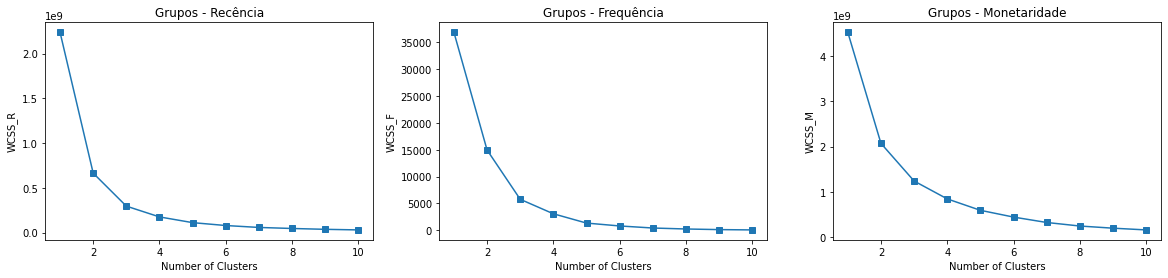

In [18]:
elbow_plots(WCSS_R=wcss_r, WCSS_F=wcss_f, WCSS_M=wcss_m)

#### 3.2.2) Valores escalonados

Iremos agora repetir o processo feito em (3.2.1) com os respectivos valores escalonados.

In [19]:
wcss_re = define_clusters(df_temp, 1, True)
wcss_fe = define_clusters(df_temp, 2, True)
wcss_me = define_clusters(df_temp, 3, True)

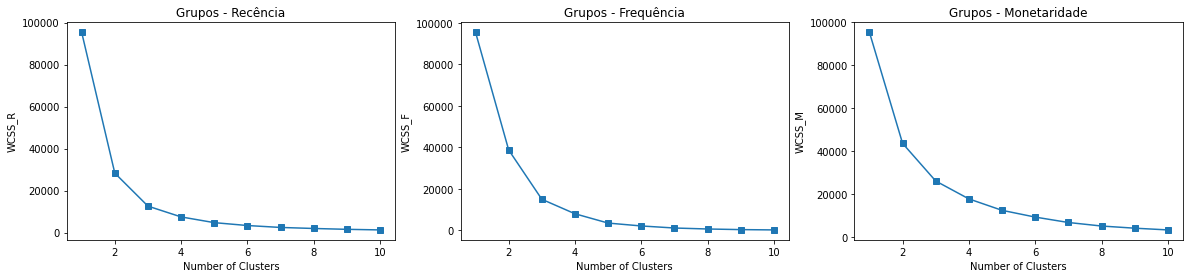

In [20]:
elbow_plots(WCSS_R=wcss_re, WCSS_F=wcss_fe, WCSS_M=wcss_me)

Note que pelos gráficos obtidos na partes (3.3.1) e (3.3.2) obtivemos resultados similares, e portanto para este caso o escalonamento das variáveis é opcional, sendo então possível utilizar ambas as abordagens. Por isso, consideraremos cinco clusters como a quantidade ideal. 

### 3.3) Fazendo o treinamento via K-Means

Definido então a quantidade de 5 agrupamentos como o ideal, podemos fazer o treinamento dos dados da maneira como segue. Além disso, de acordo com o resultado obtido criaremos labels referentes a cada grupo.

In [21]:
# Considerando portanto 5 clusters
def cluster_clients(df, column):
  """
  Função que retorna as previsões dos labels de cada cluster encontrados pelo K-Means.
  :param df: Dataframe com os respectivos dados.
  :param column: Coluna do dataframe a ser analisada.
  :return: Retorna as previsões de label para cada cluster.
  """
  X = df.iloc[:, [column]].values
  kmeans = KMeans(n_clusters=5, random_state=0)
  previsoes = kmeans.fit_predict(X)
  return previsoes

In [22]:
# Criando os labels para cada dataframe
label_r = cluster_clients(df_temp, 1)
label_f = cluster_clients(df_temp, 2)
label_m = cluster_clients(df_temp, 3)

In [23]:
# Criação de uma coluna com os labels
df_temp['R'] = label_r
df_temp['F'] = label_f
df_temp['M'] = label_m

In [24]:
# Alterando a ordem das colunas de forma apropriada
columnsTitles = ['customer_unique_id', 
                 'recency', 'R', 
                 'frequency', 'F', 
                 'monetary', 'M']

df_temp = df_temp.reindex(columns=columnsTitles)

In [25]:
df_temp.head()

,customer_unique_id,recency,R,frequency,F,monetary,M
0,0000366f3b9a7992bf8c76cfdf3221e2,116,0,1,0,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,0,1,0,18.90,0
2,0000f46a3911fa3c0805444483337064,542,1,1,0,69.00,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,2,1,0,25.99,0
4,0004aac84e0df4da2b147fca70cf8255,293,2,1,0,180.00,4


### 3.4) Rearranjando os índices dos labels

Um importante ajuste que necessita-se fazer agora é redefinir os labels R, F, M para que eles possam associar a cada grupo um grau de importância, atribuindo-se assim um "peso" para cada cluster. Neste ponto, podemos utilizar a seguinte referência:

- Recência: quanto maior, pior. Ordem de importância: 4, 3, 2, 1, 0.
- Frequência: quanto maior, melhor. Ordem de importância: 0, 1, 2, 3, 4.
- Monetaridade: quanto maior, melhor. Ordem de importância: 0, 1, 2, 3, 4.

In [26]:
df_temp.groupby('R').mean().sort_values(by='recency', ascending=False).reset_index()['R']

0    1
1    4
2    2
3    0
4    3
Name: R, dtype: int64

In [27]:
df_temp.groupby('F').mean().sort_values(by='recency', ascending=True).reset_index()['F']

0    4
1    3
2    1
3    2
4    0
Name: F, dtype: int64

In [28]:
df_temp.groupby('M').mean().sort_values(by='monetary', ascending=True).reset_index()['M']

0    0
1    4
2    1
3    3
4    2
Name: M, dtype: int64

Assim, os labels precisam ser alterados da forma:

- R: 0 -> 3; 1 -> 0; 2 -> 2; 3 -> 4; 4 -> 1.
- F: 0 -> 4; 1 -> 2; 2 -> 3; 3 -> 1; 4 -> 0.
- M: 0 -> 0; 1 -> 2; 2 -> 4; 3 -> 3; 4 -> 1.

Podemos realizar este ajusta mediante uma função.

In [29]:
def adjust_index(df, column, label, ascend):
  """
  Função que adiciona uma coluna com labels ajustados e retorna o novo dataframe.
  :param df: Dataframe que contém os respectivos dados.
  :param column: Coluna que será ordenada para ajuste dos labels.
  :param label: Coluna cujo label será ajustado.
  :param ascend: Forma de ordenar os dados. Se True ascendente; se False descendente.
  :return: Dataframe com a coluna com labels ajustados.
  """
  x = df.groupby(label).mean().sort_values(by=column, ascending=ascend).reset_index()
  index = tuple(zip(x.index, x[label].values))
  for c in index:
    df.loc[df[label] == c[1], f'adjusted_{label}'] = c[0] 
  df[f'adjusted_{label}'] = df[f'adjusted_{label}'].apply(lambda x: int(x))
  return df

In [30]:
df_temp = adjust_index(df_temp, 'recency', 'R', False)
df_temp = adjust_index(df_temp, 'frequency', 'F', True)
df_temp = adjust_index(df_temp, 'monetary', 'M', True)

In [31]:
# Alterando a ordem das colunas de forma apropriada
columnsTitles = ['customer_unique_id', 
                 'recency', 'R', 'adjusted_R' ,
                 'frequency', 'F', 'adjusted_F',
                 'monetary', 'M', 'adjusted_M']

df_temp = df_temp.reindex(columns=columnsTitles)

### 3.5) Criando o dataframe final

Podemos agora criar o dataframe final que irá exibir os clientes levando em consideração sua pontuação total (representada pela coluna score) e suas respectivas classificações (coluna RFM_level).

In [32]:
# Excluindo as colunas R, F, M e renomeando as colunas adjusted_R, adjusted_F, adjusted_M
df_final = df_temp.drop(columns=['R', 'F', 'M'])

In [33]:
# Renomeando as colunas
df_final.rename(columns={'adjusted_R': 'R',
                         'adjusted_F': 'F',
                         'adjusted_M': 'M'}, inplace=True)

In [34]:
# Criando uma coluna com a pontuação final de cada cliente
df_final['score'] = df_final['R'] + df_final['F'] + df_final['M']
df_final.head()

,customer_unique_id,recency,R,frequency,F,monetary,M,score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,3,1,0,129.90,0,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3,1,0,18.90,0,3
2,0000f46a3911fa3c0805444483337064,542,0,1,0,69.00,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,2,1,0,25.99,0,2
4,0004aac84e0df4da2b147fca70cf8255,293,2,1,0,180.00,1,3


In [35]:
# Descrição dos dados
df_final.describe()

,recency,R,frequency,F,monetary,M,score
count,95420.000000,95420.000000,95420.00000,95420.000000,95420.000000,95420.000000,95420.000000
mean,243.600377,2.289174,1.18057,0.161035,142.440198,0.286166,2.736376
std,153.160320,1.292739,0.62145,0.471841,217.656355,0.574982,1.531510
min,1.000000,0.000000,1.00000,0.000000,0.850000,0.000000,0.000000
25%,119.000000,1.000000,1.00000,0.000000,47.900000,0.000000,2.000000
50%,224.000000,2.000000,1.00000,0.000000,89.900000,0.000000,3.000000
75%,353.000000,3.000000,1.00000,0.000000,155.000000,0.000000,4.000000
max,729.000000,4.000000,24.00000,4.000000,13440.000000,4.000000,12.000000


Da tabela acima podemos ver algumas estatísticas que serão importantes na nossa análise posteriormente.

## 4) Análise exploratória de dados

Um importante passo para entender o comportamento dos dados é fazer uma análise exploratória dos mesmos e nos dedicaremos a esta tarefa nesta seção. Para isso, iremos plotar vários gráficos estatísticos que nos ajudarão a entender a nossa base de dados corretamente.

* Pairplot

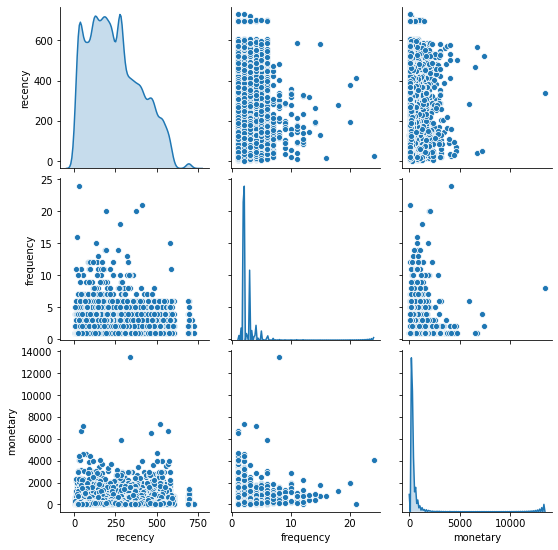

In [36]:
# Dados originais
colunas = df_final[['recency', 'frequency', 'monetary']]
sns.pairplot(data=colunas, diag_kind="kde")
plt.show()

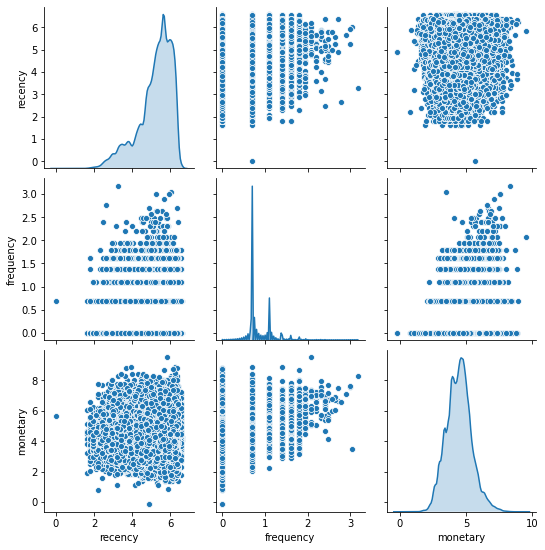

In [37]:
# Dados em escala logarítmica
colunas = df_final[['recency', 'frequency', 'monetary']]
sns.pairplot(data=np.log(colunas), diag_kind="kde")
plt.show()

Note que ao plotarmos o mesmo gráfico com os dados em escala logarítmica, seus respectivos histogramas (sobretudo de recency e monetary) se aproximam de uma distribuição normal.

* Histograma

Para criar os critérios de classificação de forma mais precisa precisamos entender como os valores do score estão distribuídos e para isso podemos plotar um histograma e analisar esta distribuição. Desta forma será possível chegar a uma conclusão com uma acurácia maior acerca de seu respectivo rótulo.

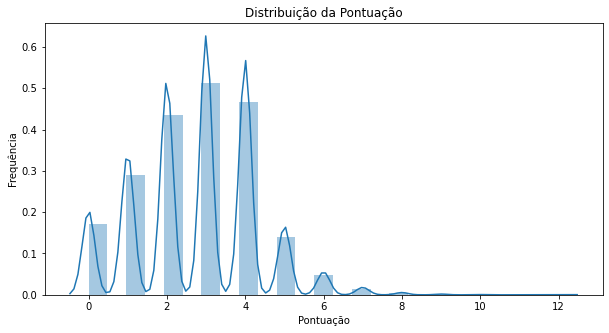

In [38]:
# Histograma do score final
fig = plt.figure(figsize=(10,5))
score = df_final['score']
sns.distplot(score, bins=25)
plt.title('Distribuição da Pontuação')
plt.xlabel('Pontuação')
plt.ylabel('Frequência')
plt.show()

* Boxplot

Uma maneira imediata de verificar outliers na base de dados é através de gráficos chamado ***boxplot***. Veremos então qual o resultado para esta distribuição.

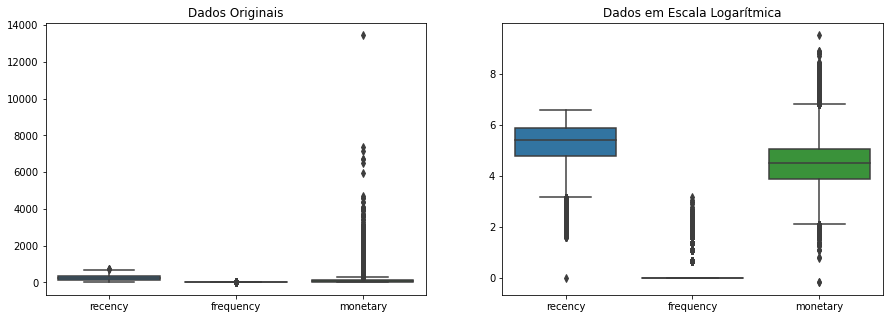

In [39]:
# Boxplot
dados = df_final[['recency', 'frequency', 'monetary']]
fig = plt.figure(figsize=(15,5))

# Escala normal
plt.subplot(1,2,1)
sns.boxplot(data=dados)
plt.title('Dados Originais')

# Escala logarítmica
plt.subplot(1,2,2)
sns.boxplot(data=np.log(dados))
plt.title('Dados em Escala Logarítmica')
plt.show()

Da figura acima, notamos que há uma grande quantidade de outliers com uma quantidade significativa deles referentes à monetaridade. Um outro problema encontrado é o fato de a feature frequency apresentar uma grande quantidade de compras unitárias, ou seja, há uma grande quantidade de clientes que compraram apenas uma vez, fazendo com que aqueles com mais de uma compra tornem-se automaticamente um outlier. Nas próximas seções daremos um tratamento adequado a esta situação.

## 5) Agrupando os clientes

### 5.1) Classificação dos clientes

Primeiramente, antes de fazer o agrupamento dos clientes, precisamos classificar cada um deles e usaremos como referência o score dos clientes. Assim, após a visualização do histograma acima e análise da descrição dos dados vemos que o valor do score está muito "deslocado para esquerda", ou seja, possui 75% dos seus valores abaixo de 4, que representa 1/3 da pontuação máxima (que é 12). Neste caso precisamos rearranjar as classificações de forma a levar em consideração este "desvio".

Assim, podemos classificar cada cliente utilizando o critério visto na função a seguir.

In [40]:
def rfm_classification(df):
  """
  Função que retorna a classificação de cada cliente de acordo com seu score.
  :param df: Dataframe com a coluna do score dos clientes.
  :param limit: Lista que indica o limite de cada uma das categorias.
  :return: Retorna a classificação podendo ela ser Ruim, Regular, Bom, Muito bom e Ótimo.
  """
  if df['score'] <= 1:
    return 'Ruim'
  elif df['score'] <= 3:
    return 'Regular'
  elif df['score'] <= 4:
    return 'Bom'
  elif df['score'] <= 5:
    return 'Muito bom'
  else:
    return 'Ótimo'

In [41]:
# Criação de uma nova coluna RMF_level
df_final['RFM_level'] = df_final.apply(rfm_classification, axis=1)
df_final.head()

,customer_unique_id,recency,R,frequency,F,monetary,M,score,RFM_level
0,0000366f3b9a7992bf8c76cfdf3221e2,116,3,1,0,129.90,0,3,Regular
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3,1,0,18.90,0,3,Regular
2,0000f46a3911fa3c0805444483337064,542,0,1,0,69.00,0,0,Ruim
3,0000f6ccb0745a6a4b88665a16c9f078,326,2,1,0,25.99,0,2,Regular
4,0004aac84e0df4da2b147fca70cf8255,293,2,1,0,180.00,1,3,Regular


### 5.2) Dados originais

Agora podemos fazer um agrupamento dos clientes considerando as variáveis recência, frequência e monetaridade duas a duas, obtendo assim três gráficos relacionando os clientes a cada uma das variáveis.

In [42]:
def scatter_plots(df):
  nomes_colunas = ('recency', 'frequency', 'monetary')
  plt.figure(figsize=(20,5))

  for i in range(3):
    plt.subplot(1,3,i+1)

    if i < 1:
      sns.scatterplot(data=df, 
                      x=df[nomes_colunas[i + 1]],
                      y=df[nomes_colunas[i]],
                      hue='RFM_level')
      eixo_x = nomes_colunas[i + 1].title()
      eixo_y = nomes_colunas[i].title()
    else:
      sns.scatterplot(data=df, 
                      x=df[nomes_colunas[-i - 1]], 
                      y='monetary', 
                      hue='RFM_level')
      eixo_x = nomes_colunas[-i - 1].title()
      eixo_y = 'Monetary'
      
    plt.title(f'{eixo_y} x {eixo_x}')
  plt.show()  

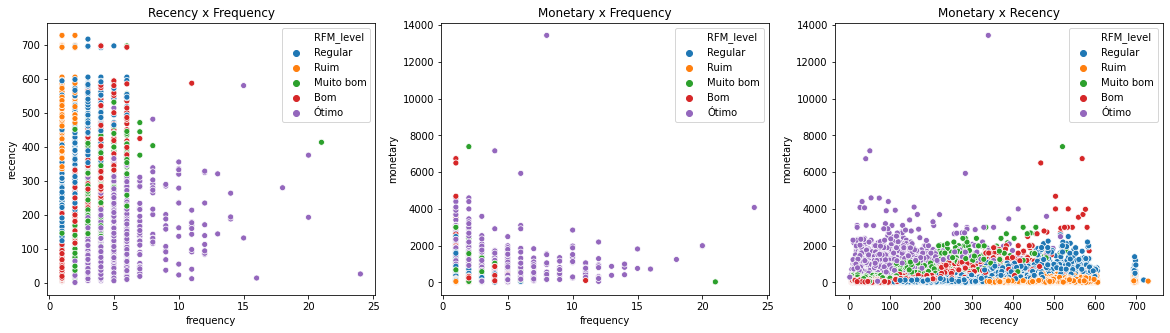

In [43]:
scatter_plots(df_final)

Ao visualizar os plots acima, vemos que além de termos alguns valores discrepantes (sobretudo nos gráficos envolvendo a monetaridade) ainda temos uma distribuição da classificação "ótimo" que aparentemente está exagerada. Para isso, iremos verificar se nossos resultados estão sofrendo alguma perda de qualidade devido aos outliers, ou seja, esses valores extremamente foras do padrão.

### 5.3) Dados sem outliers

Nesta etapa iremos trabalhar em duas frentes:

- Analisaremos os dados desprezando os outliers.
- Faremos uma análise específica desses outliers.

Portanto iremos identificar e remover os outliers e analisar o comportamento das variáveis. Para isso vamos usar um algorítmo próprio do Python para identificar os clientes que possam ser considerados como outliers.

#### 5.3.1) Eliminando os outliers 

Para remover os outliers usaremos uma biblioteca chamada [PyOD](https://pyod.readthedocs.io/en/latest/) que, juntamente com o algorítmo KNN irá identificar os outliers em nossa base de dados calculando a distância entre os registros e assim, retornando os índices dos mesmos. Seguimos então com a sua implementação.

In [44]:
# Criando o detector de outliers
detector = KNN()
detector.fit(df_final.iloc[:, [1, 3, 5]])

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [45]:
# Obtendo as previsões, onde: 0 não é outlier; 1 é outlier
previsoes = detector.labels_
previsoes

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
detector.decision_scores_

array([1.00404183, 0.99      , 1.        , ..., 2.        , 1.        ,
       1.5697452 ])

In [47]:
# Gerando uma lista com os índices dos outliers
outliers = [i for i in range(len(previsoes)) if previsoes[i] == 1]
print(f'Total de outliers: {len(outliers)}')

Total de outliers: 9541


In [48]:
# Dataframe dos outliers
df_outliers = df_final.iloc[outliers, :]
df_outliers.head()

,customer_unique_id,recency,R,frequency,F,monetary,M,score,RFM_level
8,0005e1862207bf6ccc02e4228effd9a0,548,0,1,0,135.00,0,0,Ruim
22,000fbf0473c10fc1ab6f8d2d286ce20c,39,4,4,2,285.80,1,7,Ótimo
27,0011805441c0d1b68b48002f1d005526,497,0,1,0,269.00,1,1,Ruim
28,0011857aff0e5871ce5eb429f21cdaf5,432,1,1,0,174.33,1,2,Regular
55,0028a7d8db7b0247652509358ad8d755,264,2,1,0,274.00,1,3,Regular


In [49]:
# Dataframe sem os outliers
df_no_outliers = df_final.drop(index=outliers)
df_no_outliers.head()

,customer_unique_id,recency,R,frequency,F,monetary,M,score,RFM_level
0,0000366f3b9a7992bf8c76cfdf3221e2,116,3,1,0,129.90,0,3,Regular
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3,1,0,18.90,0,3,Regular
2,0000f46a3911fa3c0805444483337064,542,0,1,0,69.00,0,0,Ruim
3,0000f6ccb0745a6a4b88665a16c9f078,326,2,1,0,25.99,0,2,Regular
4,0004aac84e0df4da2b147fca70cf8255,293,2,1,0,180.00,1,3,Regular


In [50]:
df_no_outliers.describe()

,recency,R,frequency,F,monetary,M,score
count,85879.000000,85879.000000,85879.000000,85879.000000,85879.000000,85879.000000,85879.000000
mean,239.145961,2.322186,1.126049,0.121939,98.630547,0.159597,2.603722
std,149.903428,1.273085,0.405695,0.379575,85.130197,0.382806,1.412343
min,5.000000,0.000000,1.000000,0.000000,3.900000,0.000000,0.000000
25%,119.000000,1.000000,1.000000,0.000000,43.990000,0.000000,2.000000
50%,221.000000,2.000000,1.000000,0.000000,79.400000,0.000000,3.000000
75%,343.000000,3.000000,1.000000,0.000000,129.990000,0.000000,4.000000
max,701.000000,4.000000,5.000000,3.000000,1999.990000,3.000000,8.000000


In [51]:
# Shape dos dataframes recém criados
print(f'Dataframe dos outliers: {df_outliers.shape} \nDataframe sem os outliers: {df_no_outliers.shape}')

Dataframe dos outliers: (9541, 9) 
Dataframe sem os outliers: (85879, 9)


In [52]:
# Salvando dataframe dos outliers em arquivo .csv
df_outliers.to_csv('outliers.csv', index=False)

#### 5.3.2) Scatter plot

Assim, podemos refazer o scatter plot de anteriormente com os novos dados sem os outliers.

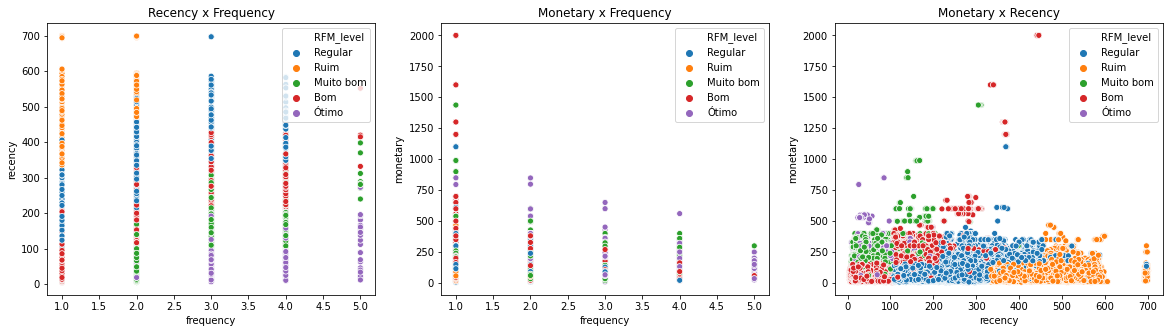

In [53]:
scatter_plots(df_no_outliers)

Ao analisar os gráficos acima vemos que há uma grande diferença em relação aos plots obtidos na subseção (5.2). Isso nos leva a concluir que os outliers de fato prejudicaram o modelo e precisaram ser tratados (neste caso, o tratamento escolhido foi a simples remoção). Note ainda que a proporção entre as classificações está totalmente compatível com a quantidade de pontos de cada um, o que nos leva a crer que este modelo apresenta-se bem realista.

## 6) Agrupamento geral

Por fim, criaremos um diagrama com a quantidade de clientes em cada categoria. Este diagrama nos dará uma noção visual do quão grande é a discrepância de uma categoria para outra no que diz respeito a sua quantidade.

In [54]:
# Cálculo dos valores médios para RMF_level
rfm_level_agg = df_no_outliers.groupby('RFM_level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
})

In [55]:
rfm_level_agg

recency frequency    monetary       
                 mean      mean        mean  count
RFM_level                                         
Bom         89.346168  1.141430  108.953800  19713
Muito bom   84.666739  1.582226  199.217754   4591
Regular    231.042379  1.077416   90.162285  40586
Ruim       447.520361  1.029151   76.204284  19965
Ótimo       74.023438  2.601562  221.809346   1024

In [56]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

###  6.1) Plotando o diagrama

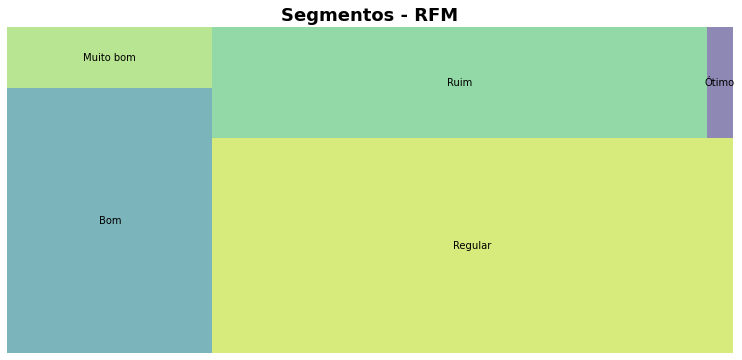

In [57]:
# Plotando o respectivo diagrama
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13,6)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Bom',
                     'Muito bom',
                     'Regular',
                     'Ruim',                                          
                     'Ótimo',
                     ], alpha=.6 )
plt.title("Segmentos - RFM",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

## 7) Escrevendo o resultado em uma planilha

Por fim podemos escrever o dataframe final em uma planilha do excel onde em cada aba estará uma classificação. Desta forma poderemos consultar de forma fácil e rápida os respectivos clientes de acordo com o seu id.

In [58]:
def write_excel(df, col):
  """
  Função que escreve o dataframe final em uma planilha do excel.
  :param df: Dataframe final.
  :param col: Coluna com a classificação dos grupos.
  """
  classificacoes = df[col].unique()
  for ind, classificacao in enumerate(classificacoes):    
      y =  df.query(f'{col} == "{classificacao}"')
      if ind == 0:
          y.to_excel('classificacao.xlsx', sheet_name=classificacao, index=False)
      else:
          writer = pd.ExcelWriter('classificacao.xlsx', engine='openpyxl', mode='a')
          y.to_excel(writer, sheet_name=classificacao, index=False)
          writer.save()
  writer.close()

In [59]:
write_excel(df_no_outliers, 'RFM_level')

## 8) Conclusão

Após fazer esta análise com os dados da Olist é possível notar que a grande maioria dos clientes encontra-se como um cliente da categoria regular, ou seja, que apresenta em média uma recência de 239 dias, frequência de 1,12 vezes e um gasto de R$ 98,63.

Uma outra observação que faz sentido é o fato de que os clientes considerados "ótimos" apresentam-se em minoria e respondem por uma média de 74,02 dias, 2,60 vezes e R$ 221,81 nos quesitos recência, frequência e monetaridade respectivamente. Ao todo, atingem a marca de 1024 clientes com este comportamento. Para este grupo faria sentido também oferecer alguma espécie de vantagem como um cartão exclusivo de fidelidade, programa de "milhagens" de compras, etc. 

Uma outra informação relevante é o fato de encontramos a presença massiva de clientes com apenas uma única compra, o que pode significar um descontentamento com o serviço oferecido, precisando de uma análise mais profunda do caso. Alguns motivos bem possíveis podem estar relacionados a qualidade dos produtos em si, do preço ou do serviço de entregas. Neste ponto, uma alternativa seria uma atenção melhor por parte do vendedor com um atendimento mais individualizado ou até mesmo disponibilização de cupons de desconto como um incentivo para o cliente voltar a consumir regularmente.